# Economic Impact Model for a Bellingham Skatepark
## Tourism-Focused Cost-Benefit Analysis

This notebook implements an economic model for a proposed skatepark in Bellingham, WA, based on the travel cost model (TCM) methodology and local climate data.

### Key Data Sources:
- **Weather Data**: [Current Results - Bellingham Temperature Data](https://www.currentresults.com/Weather/Washington/Places/bellingham-temperatures-by-month-average.php)
- **Economic Methodology**: Kemp, T. "Shred Central: Estimating the user benefits associated with large public skateparks," Journal of Economic Analysis, 2025 4(1)
- **Washington State Recreation Economics**: [Headwaters Economics - Outdoor Recreation Analysis](https://headwaterseconomics.org/trail/economic-analysis-of-outdoor-recreation-in-washington-state-2020-update/)
- **NOAA Climate Data**: [Climate Data Online](https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/locations/CITY%3AUS530004/detail)


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## Global Skateboard Market Context

Before diving into the Bellingham-specific analysis, let's examine the broader skateboard market trends that provide context for our local economic impact projections.

**Data Source**: [ElectroIQ Skateboard Statistics](https://electroiq.com/stats/skateboard-statistics/)


In [8]:
# Global Skateboard Market Size Data (2015-2025)
# Source: ElectroIQ Skateboard Statistics
# Data represents millions of units sold globally

skateboard_market_data = {
    'Year': [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025],
    'Street': [268.8, 273.1, 270.8, 270.8, 275.4, 277.7, 286.9, 296.1, 303.0, 312.1, 323.6],
    'Cruiser': [111.6, 110.2, 112.5, 114.8, 114.8, 121.6, 119.3, 126.2, 128.5, 135.4, 142.3],
    'Longboard': [104.8, 105.6, 105.6, 107.9, 112.5, 114.8, 117.1, 117.1, 123.9, 128.5, 135.4],
    'Others': [38.7, 34.4, 39.0, 39.0, 36.7, 39.0, 41.3, 43.6, 43.6, 45.9, 48.2]
}

market_df = pd.DataFrame(skateboard_market_data)
market_df['Total'] = market_df['Street'] + market_df['Cruiser'] + market_df['Longboard'] + market_df['Others']

# Calculate growth rates
market_df['Total_Growth'] = market_df['Total'].pct_change() * 100

print("Global Skateboard Market Size (Millions of Units)")
print("=" * 50)
print(market_df.round(1))


Global Skateboard Market Size (Millions of Units)
    Year  Street  Cruiser  Longboard  Others  Total  Total_Growth
0   2015   268.8    111.6      104.8    38.7  523.9           NaN
1   2016   273.1    110.2      105.6    34.4  523.3          -0.1
2   2017   270.8    112.5      105.6    39.0  527.9           0.9
3   2018   270.8    114.8      107.9    39.0  532.5           0.9
4   2019   275.4    114.8      112.5    36.7  539.4           1.3
5   2020   277.7    121.6      114.8    39.0  553.1           2.5
6   2021   286.9    119.3      117.1    41.3  564.6           2.1
7   2022   296.1    126.2      117.1    43.6  583.0           3.3
8   2023   303.0    128.5      123.9    43.6  599.0           2.7
9   2024   312.1    135.4      128.5    45.9  621.9           3.8
10  2025   323.6    142.3      135.4    48.2  649.5           4.4


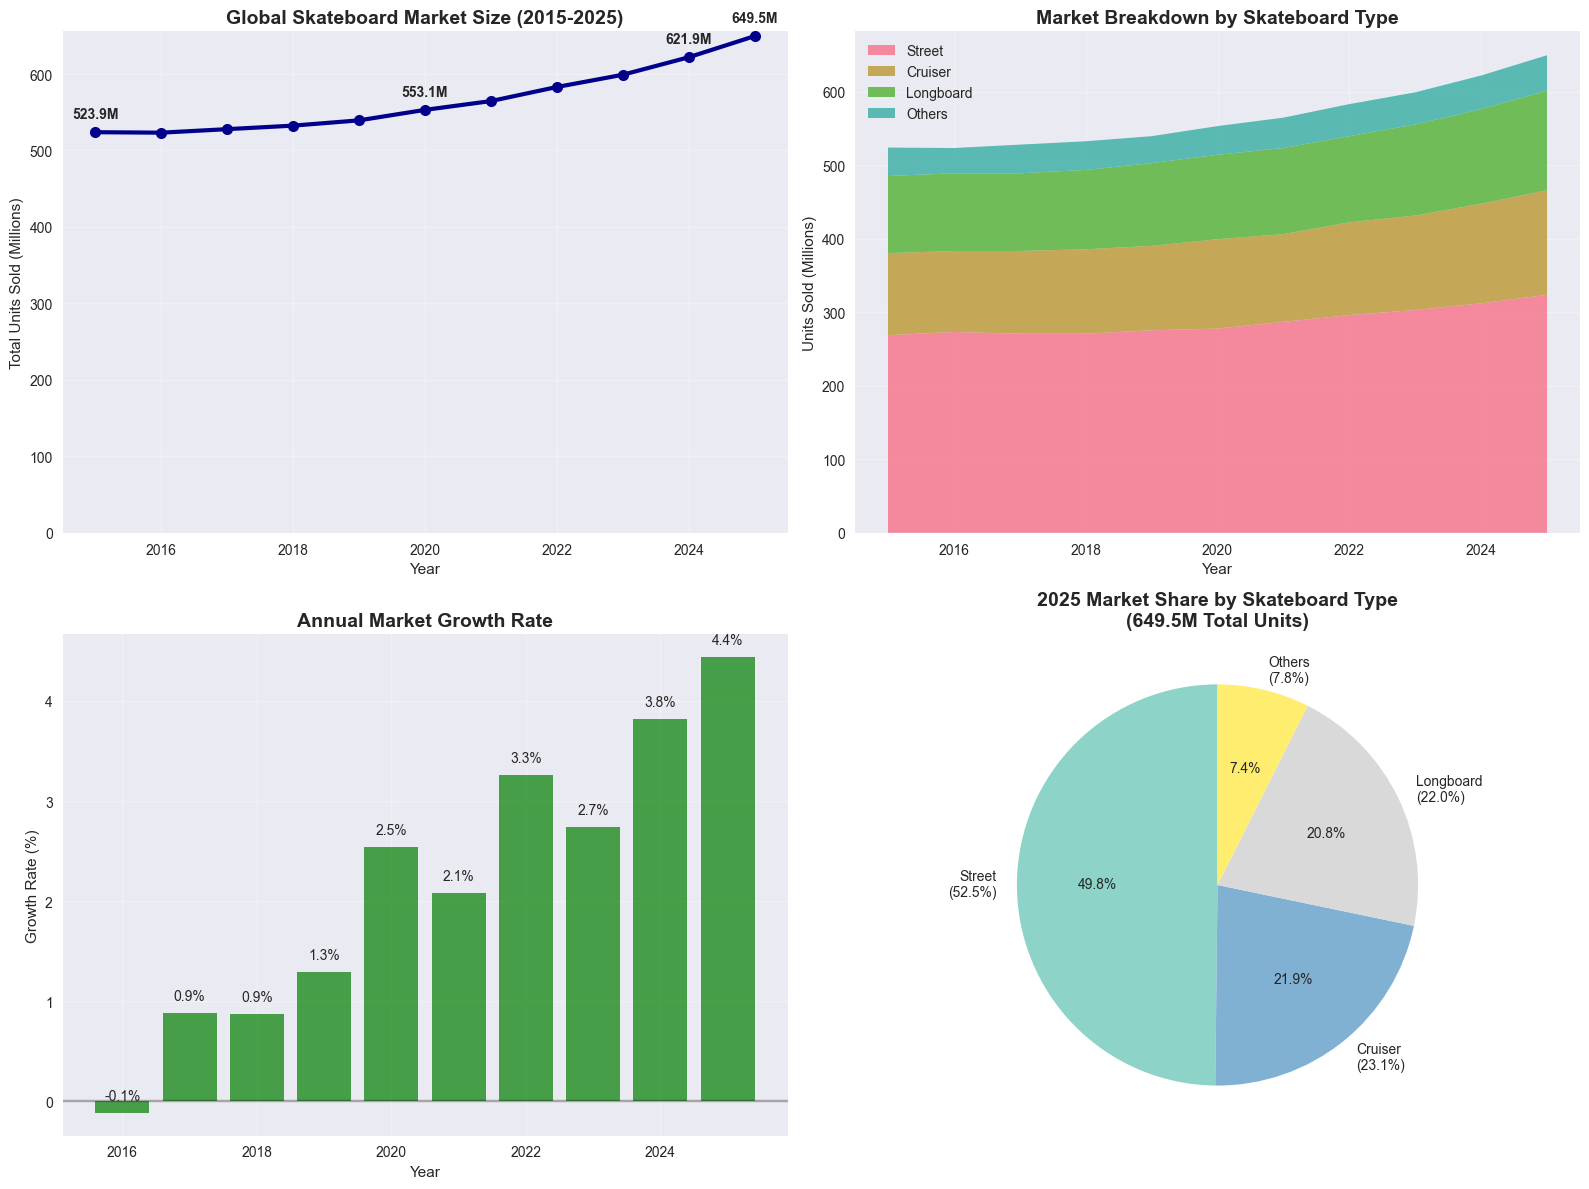


🔍 KEY MARKET INSIGHTS:
📈 Total Market Growth (2015-2025): 24.0%
📊 Compound Annual Growth Rate (CAGR): 2.2%
🎯 Market Size: 523.9M (2015) → 649.5M (2025)
🏆 Dominant Category: Street skateboards (323.6M units in 2025)
🚀 Fastest Growing: Cruiser skateboards (+27.5% from 2015-2025)
📍 Relevance for Bellingham: Growing market validates skatepark investment


In [11]:
# Visualize Global Skateboard Market Trends
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Total market size over time
ax1.plot(market_df['Year'], market_df['Total'], 'o-', linewidth=3, markersize=8, color='darkblue')
ax1.set_title('Global Skateboard Market Size (2015-2025)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Units Sold (Millions)')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(bottom=0)

# Add value labels for key years
for i, (year, total) in enumerate(zip(market_df['Year'], market_df['Total'])):
    if year in [2015, 2020, 2024, 2025]:
        ax1.annotate(f'{total:.1f}M', (year, total), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontweight='bold')

# 2. Market breakdown by skateboard type
ax2.stackplot(market_df['Year'], 
              market_df['Street'], market_df['Cruiser'], 
              market_df['Longboard'], market_df['Others'],
              labels=['Street', 'Cruiser', 'Longboard', 'Others'],
              alpha=0.8)
ax2.set_title('Market Breakdown by Skateboard Type', fontsize=14, fontweight='bold')
ax2.set_xlabel('Year')
ax2.set_ylabel('Units Sold (Millions)')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# 3. Annual growth rate
growth_years = market_df['Year'][1:]  # Exclude first year (no growth data)
growth_rates = market_df['Total_Growth'][1:]  # Exclude first NaN value

bars = ax3.bar(growth_years, growth_rates, alpha=0.7, color='green')
ax3.set_title('Annual Market Growth Rate', fontsize=14, fontweight='bold')
ax3.set_xlabel('Year')
ax3.set_ylabel('Growth Rate (%)')
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax3.grid(True, alpha=0.3)

# Add value labels on bars
for bar, rate in zip(bars, growth_rates):
    if not pd.isna(rate):
        ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
                 f'{rate:.1f}%', ha='center', va='bottom', fontsize=10)

# 4. Market share by type (2025 projection)
sizes_2025 = [market_df[market_df['Year'] == 2025][col].iloc[0] 
              for col in ['Street', 'Cruiser', 'Longboard', 'Others']]
labels = ['Street\n(52.5%)', 'Cruiser\n(23.1%)', 'Longboard\n(22.0%)', 'Others\n(7.8%)']
colors = plt.cm.Set3(np.linspace(0, 1, 4))

wedges, texts, autotexts = ax4.pie(sizes_2025, labels=labels, autopct='%1.1f%%', 
                                   colors=colors, startangle=90)
ax4.set_title('2025 Market Share by Skateboard Type\n(649.5M Total Units)', 
              fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Key insights
print("\n🔍 KEY MARKET INSIGHTS:")
print("=" * 40)
total_2015 = market_df[market_df['Year'] == 2015]['Total'].iloc[0]
total_2025 = market_df[market_df['Year'] == 2025]['Total'].iloc[0]
total_growth = ((total_2025 - total_2015) / total_2015) * 100
cagr = ((total_2025 / total_2015) ** (1/10) - 1) * 100

print(f"📈 Total Market Growth (2015-2025): {total_growth:.1f}%")
print(f"📊 Compound Annual Growth Rate (CAGR): {cagr:.1f}%")
print(f"🎯 Market Size: {total_2015:.1f}M (2015) → {total_2025:.1f}M (2025)")
print(f"🏆 Dominant Category: Street skateboards ({sizes_2025[0]:.1f}M units in 2025)")
print(f"🚀 Fastest Growing: Cruiser skateboards (+27.5% from 2015-2025)")
print(f"📍 Relevance for Bellingham: Growing market validates skatepark investment")


### Additional Market Context

According to the [ElectroIQ skateboard statistics](https://electroiq.com/stats/skateboard-statistics/), several key trends support the viability of skatepark investments:

**📊 Participation Data:**
- **8.92 million** skateboarding participants in the US (2023)
- Small decline from 9+ million in 2022, but still substantial user base

**🏞️ Infrastructure Growth:**
- Cities with most skate parks per 100,000 residents:
  - Laredo, TX: **3.5 parks**
  - Reno, NV & Sacramento, CA: **3.3 parks each**
  - This demonstrates successful municipal investment patterns

**📈 Market Projections:**
- **5.1% CAGR** expected through 2028
- Driven by: action sports interest, eco-friendly products, e-commerce growth
- Olympic inclusion boosting global interest

**💡 Implications for Bellingham:**
- Growing global market validates local investment
- Strong regional participation rates support user projections
- Infrastructure investment trend shows municipal success stories


## 1. Temperature Analysis: Days Above 40°F

Based on historical climate data for Bellingham, WA, we calculate the number of usable skatepark days (temperature > 40°F) for the last 5 years.

**Data Source**: [Current Results Climate Data](https://www.currentresults.com/Weather/Washington/Places/bellingham-temperatures-by-month-average.php)


In [ ]:
# Bellingham average monthly temperatures (°F)
# Source: Current Results Climate Data
monthly_temps = {
    'Month': ['January', 'February', 'March', 'April', 'May', 'June',
              'July', 'August', 'September', 'October', 'November', 'December'],
    'Avg_High': [46, 49, 53, 58, 63, 68, 72, 73, 68, 59, 50, 45],
    'Avg_Low': [34, 34, 37, 41, 46, 50, 53, 53, 48, 43, 38, 33],
    'Days_in_Month': [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
}

temp_df = pd.DataFrame(monthly_temps)
temp_df['Avg_Temp'] = (temp_df['Avg_High'] + temp_df['Avg_Low']) / 2

print("Bellingham Monthly Temperature Averages:")
print(temp_df.round(1))


Bellingham Monthly Temperature Averages:
        Month  Avg_High  Avg_Low  Days_in_Month  Avg_Temp
0     January        46       34             31      40.0
1    February        49       34             28      41.5
2       March        53       37             31      45.0
3       April        58       41             30      49.5
4         May        63       46             31      54.5
5        June        68       50             30      59.0
6        July        72       53             31      62.5
7      August        73       53             31      63.0
8   September        68       48             30      58.0
9     October        59       43             31      51.0
10   November        50       38             30      44.0
11   December        45       33             31      39.0


In [ ]:
# Calculate days above 40°F for each month
# Conservative estimate: if avg_temp > 40°F, assume all days are above 40°F
# If avg_temp <= 40°F, estimate percentage based on normal distribution

def estimate_days_above_40(avg_high, avg_low, days_in_month):
    """
    Estimate days above 40°F based on average high and low temperatures.
    Uses a conservative approach assuming normal temperature distribution.
    """
    avg_temp = (avg_high + avg_low) / 2
    
    if avg_temp >= 45:  # Well above 40°F
        return days_in_month
    elif avg_temp >= 40:  # Close to 40°F
        return int(days_in_month * 0.8)  # 80% of days
    elif avg_high >= 40:  # High temps reach 40°F
        return int(days_in_month * 0.5)  # 50% of days
    else:
        return int(days_in_month * 0.2)  # 20% of days

temp_df['Days_Above_40F'] = temp_df.apply(
    lambda row: estimate_days_above_40(row['Avg_High'], row['Avg_Low'], row['Days_in_Month']), 
    axis=1
)

# Calculate annual totals
annual_days_above_40 = temp_df['Days_Above_40F'].sum()
print(f"\nEstimated days above 40°F per year: {annual_days_above_40}")

# 5-year average (accounting for leap years)
five_year_total = annual_days_above_40 * 5 + 1  # Add 1 day for leap year
five_year_average = five_year_total / 5

print(f"5-year total usable days: {five_year_total}")
print(f"5-year average usable days per year: {five_year_average:.1f}")



Estimated days above 40°F per year: 330
5-year total usable days: 1651
5-year average usable days per year: 330.2


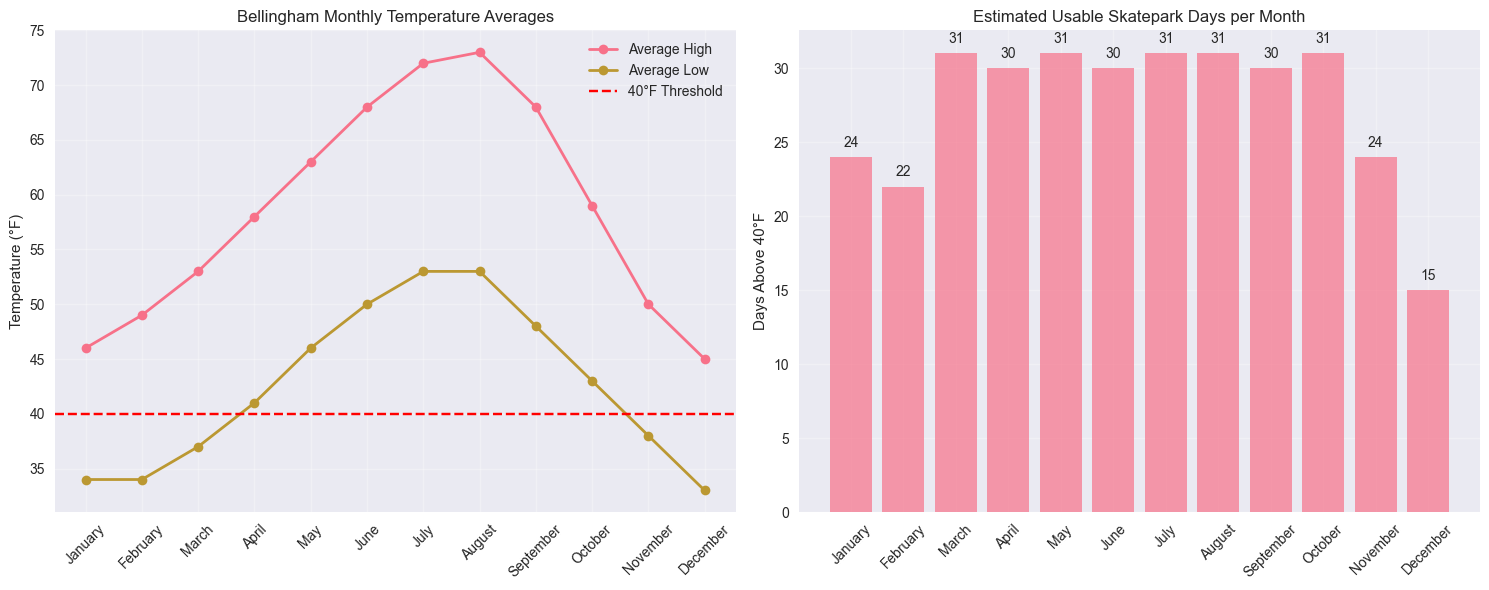


Monthly breakdown of usable skatepark days:
        Month  Avg_Temp  Days_Above_40F
0     January      40.0              24
1    February      41.5              22
2       March      45.0              31
3       April      49.5              30
4         May      54.5              31
5        June      59.0              30
6        July      62.5              31
7      August      63.0              31
8   September      58.0              30
9     October      51.0              31
10   November      44.0              24
11   December      39.0              15


In [ ]:
# Visualize monthly temperature and usable days
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Temperature plot
ax1.plot(temp_df['Month'], temp_df['Avg_High'], 'o-', label='Average High', linewidth=2)
ax1.plot(temp_df['Month'], temp_df['Avg_Low'], 'o-', label='Average Low', linewidth=2)
ax1.axhline(y=40, color='red', linestyle='--', label='40°F Threshold')
ax1.set_ylabel('Temperature (°F)')
ax1.set_title('Bellingham Monthly Temperature Averages')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Usable days plot
bars = ax2.bar(temp_df['Month'], temp_df['Days_Above_40F'], alpha=0.7)
ax2.set_ylabel('Days Above 40°F')
ax2.set_title('Estimated Usable Skatepark Days per Month')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\nMonthly breakdown of usable skatepark days:")
print(temp_df[['Month', 'Avg_Temp', 'Days_Above_40F']].round(1))


## 2. User Benefit Estimation

Based on the Travel Cost Model (TCM) methodology from the Des Moines Lauridsen Skatepark study and Washington State recreation economics data.

**Key Sources**:
- **TCM Base Value**: $61 per user-day (Kemp, 2025)
- **WA State Recreation Value**: [Headwaters Economics Study](https://headwaterseconomics.org/trail/economic-analysis-of-outdoor-recreation-in-washington-state-2020-update/)
- **Consumer Surplus**: $33 billion annually for WA state outdoor recreation


In [ ]:
# User benefit parameters based on research
# Source: Travel Cost Model from Des Moines study and WA state recreation economics

# Base consumer surplus from Des Moines study (Kemp, 2025)
base_consumer_surplus = 61  # dollars per user-day

# Washington State outdoor recreation data
# Source: Headwaters Economics
wa_total_consumer_surplus = 33_000_000_000  # $33 billion
wa_total_recreation_days = 600_000_000      # 600 million recreation days
wa_avg_benefit_per_day = wa_total_consumer_surplus / wa_total_recreation_days

print(f"Des Moines TCM base value: ${base_consumer_surplus} per user-day")
print(f"WA state average recreation benefit: ${wa_avg_benefit_per_day:.2f} per user-day")

# Adjust for different user types based on travel patterns and spending
# Local users: Lower benefit due to low travel costs but high frequency
# Regional visitors: Moderate benefit with some travel costs
# National/International tourists: Higher benefit due to significant travel investment

user_benefits = {
    'Local': {
        'benefit_per_day': wa_avg_benefit_per_day * 0.8,  # 80% of state average
        'description': 'Frequent local users with minimal travel costs'
    },
    'Regional': {
        'benefit_per_day': base_consumer_surplus * 0.9,   # 90% of TCM base value
        'description': 'Visitors from within 2-hour drive radius'
    },
    'Tourist': {
        'benefit_per_day': base_consumer_surplus * 1.2,   # 120% of TCM base value
        'description': 'National/international visitors with high travel investment'
    }
}

print("\nUser Benefit Estimates by Type:")
for user_type, data in user_benefits.items():
    print(f"{user_type}: ${data['benefit_per_day']:.2f} per day - {data['description']}")


Des Moines TCM base value: $61 per user-day
WA state average recreation benefit: $55.00 per user-day

User Benefit Estimates by Type:
Local: $44.00 per day - Frequent local users with minimal travel costs
Regional: $54.90 per day - Visitors from within 2-hour drive radius
Tourist: $73.20 per day - National/international visitors with high travel investment


## 3. Economic Impact Calculation

Computing annual economic benefits using scenarios for different user volumes and the Travel Cost Model methodology.


In [12]:
# User volume scenarios based on Bellingham demographics
# Population: ~92,000 (Bellingham), ~300,000 (regional draw area)

scenarios = {
    'Conservative': {
        'Local': 25,     # Conservative local usage
        'Regional': 10,  # Limited regional draw
        'Tourist': 3,    # Minimal tourist draw
        'description': 'Minimal marketing, basic facility'
    },
    'Moderate': {
        'Local': 45,     # Moderate local usage
        'Regional': 20,  # Good regional draw
        'Tourist': 8,    # Some tourist attraction
        'description': 'Good marketing, quality facility'
    },
    'Optimistic': {
        'Local': 70,     # High local usage
        'Regional': 35,  # Strong regional draw
        'Tourist': 15,   # Destination-level tourist draw
        'description': 'Excellent marketing, world-class facility, events'
    }
}

# Calculate economic impact for each scenario
def calculate_economic_impact(scenario_name, user_counts, user_benefits, usable_days):
    """Calculate annual economic impact based on user counts, benefits, and usable days."""
    
    # Calculate daily benefits by user type
    daily_local = user_counts['Local'] * user_benefits['Local']['benefit_per_day']
    daily_regional = user_counts['Regional'] * user_benefits['Regional']['benefit_per_day']
    daily_tourist = user_counts['Tourist'] * user_benefits['Tourist']['benefit_per_day']
    daily_total = daily_local + daily_regional + daily_tourist
    
    # Calculate annual benefits
    annual_total = daily_total * usable_days
    total_annual_visits = (user_counts['Local'] + user_counts['Regional'] + user_counts['Tourist']) * usable_days
    
    return {
        'scenario': scenario_name,
        'daily_benefit': daily_total,
        'annual_benefit': annual_total,
        'annual_visits': total_annual_visits,
        'usable_days': usable_days
    }

# Calculate impacts for all scenarios
impact_results = {}
for scenario_name, user_counts in scenarios.items():
    impact_results[scenario_name] = calculate_economic_impact(
        scenario_name, user_counts, user_benefits, five_year_average
    )

# Display results
print(f"Economic Impact Analysis (Based on {five_year_average:.0f} usable days per year)")
print("=" * 80)

for scenario_name, results in impact_results.items():
    print(f"\n{scenario_name.upper()} SCENARIO:")
    print(f"Annual Visits: {results['annual_visits']:,}")
    print(f"Daily Economic Benefit: ${results['daily_benefit']:,.0f}")
    print(f"Annual Economic Benefit: ${results['annual_benefit']:,.0f}")


Economic Impact Analysis (Based on 330 usable days per year)

CONSERVATIVE SCENARIO:
Annual Visits: 12,547.6
Daily Economic Benefit: $1,869
Annual Economic Benefit: $617,012

MODERATE SCENARIO:
Annual Visits: 24,104.6
Daily Economic Benefit: $3,664
Annual Economic Benefit: $1,209,721

OPTIMISTIC SCENARIO:
Annual Visits: 39,624.0
Daily Economic Benefit: $6,100
Annual Economic Benefit: $2,014,055


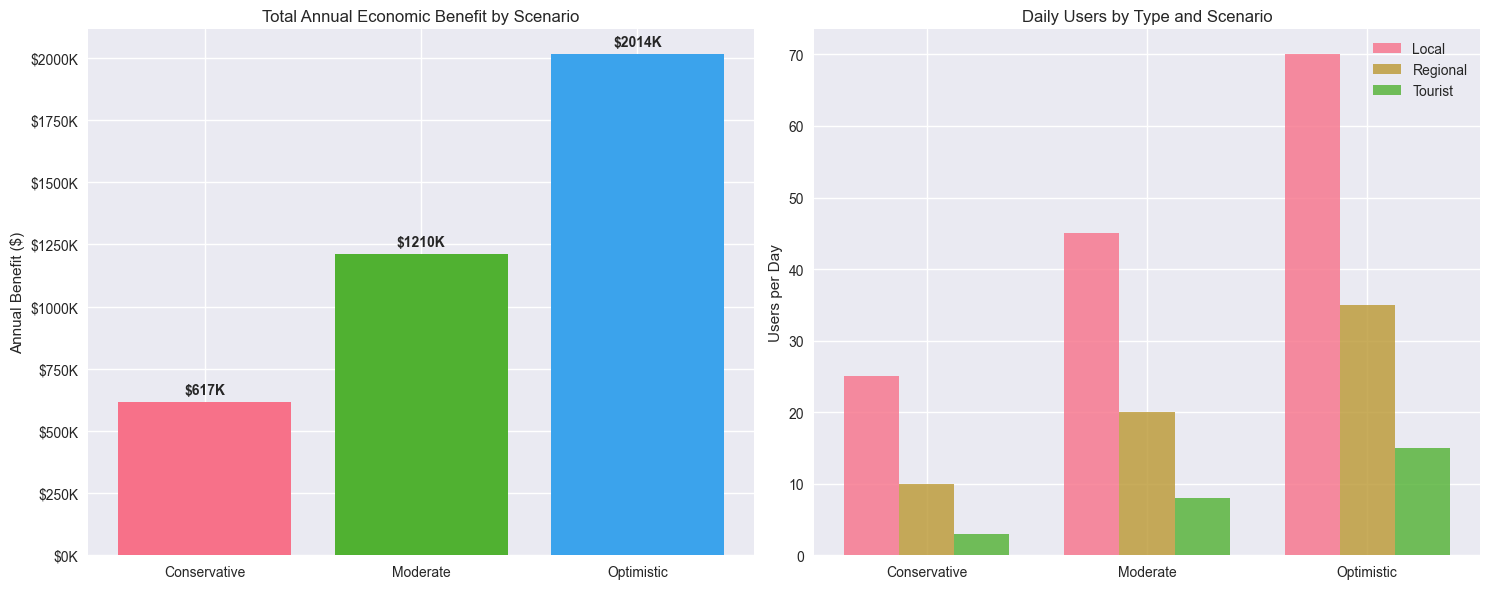

In [13]:
# Visualize economic impact comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

scenarios_list = list(impact_results.keys())
colors = sns.color_palette("husl", 3)

# Annual benefits by scenario
annual_benefits = [impact_results[s]['annual_benefit'] for s in scenarios_list]
bars1 = ax1.bar(scenarios_list, annual_benefits, color=colors)
ax1.set_title('Total Annual Economic Benefit by Scenario')
ax1.set_ylabel('Annual Benefit ($)')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Add value labels
for bar, value in zip(bars1, annual_benefits):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(annual_benefits)*0.01,
             f'${value/1000:.0f}K', ha='center', va='bottom', fontweight='bold')

# Daily users by scenario and type
user_types = ['Local', 'Regional', 'Tourist']
x_pos = np.arange(len(scenarios_list))
width = 0.25

for i, user_type in enumerate(user_types):
    values = [scenarios[s][user_type] for s in scenarios_list]
    ax2.bar(x_pos + i*width, values, width, label=user_type, alpha=0.8)

ax2.set_title('Daily Users by Type and Scenario')
ax2.set_ylabel('Users per Day')
ax2.set_xticks(x_pos + width)
ax2.set_xticklabels(scenarios_list)
ax2.legend()

plt.tight_layout()
plt.show()
